# Different HVs

- COMSOL files in /Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/03.new_chamber/07.final_design/07.final_design.no_extraction/HV

- HV is 60, 80, 100, 120, 140 kV

- bias voltage is -1.4 kV

- 1 mA ion beam current


In [1]:
import pandas as pd
import numpy as np
import os
import sys
import re
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import curve_fit

from scipy.stats import kde
from scipy import optimize

from matplotlib.ticker import NullFormatter
from matplotlib import pyplot, transforms
import matplotlib
from matplotlib.ticker import AutoMinorLocator
%matplotlib inline
import os
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'
plt.rc('text', usetex=True)
plt.rc('font', weight='bold')
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Arial'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.tt'] = 'Arial'
matplotlib.rcParams['mathtext.cal'] = 'Arial'
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']




['02_new.txt']

## Function to process the COMSOL output (column headers with commas are a problem)

In [4]:
def preprocess_COMSOL_sweep(fname, sweep_vals):
    """
    fname: csv file of COMSOL output to read
    sweep_vals: what are the sweep values in a list
    
    Returns a dictionary with the dataframes qx qy qz for each file
    """
    
    # read the data and format the , correctly
    data = pd.read_csv(fname, skiprows=8, index_col=0, nrows=10, delimiter=r'\s+', header=None)
    with open(fname, 'r') as file:
        for line in file:
            if 'Index' in line:
                cols = line.rstrip().split(',')
                break
        file.close()
    col_str = ''.join(cols)
    col_str = col_str.replace('q', ' ,q')
    col_list = col_str.split(',')
    col_list = col_list[1:]



    # read the data again, use the columns found before as the headers
    data = pd.read_csv(fname, skiprows=8, index_col=0, header=None, delimiter=r'\s+')
    data.columns = col_list

    # filter the columns
    d_sweep = {}
    # dictionary of the dataframes, each dataframe is a separate sweep value
    dic_dfs = {}
    for val in sweep_vals:
        cols = [c for c in data.columns if val in c]
        d_sweep[val] = cols

    # add each dataframe to a separate place in the dictionary
    for key in d_sweep.keys():
        this_data = data.loc[:,d_sweep[key]]
        # rename the columns in qx, qy, qz
        new_cols = []
        for c in cols:
            if 'qx' in c:
                new_cols.append('qx')
            if 'qy' in c:
                new_cols.append('qy')
            if 'qz' in c:
                new_cols.append('qz')
        this_data.columns = new_cols

        dic_dfs[key] = this_data

    return dic_dfs

In [10]:
def preprocess_COMSOL(fname):
    """
    fname: csv file of COMSOL output to read
    
    Returns a dictionary with the dataframes qx qy qz for each file
    """
    
    # read the data and format the , correctly
    data = pd.read_csv(fname, skiprows=8, index_col=0, nrows=10, delimiter=r'\s+', header=None)
    with open(fname, 'r') as file:
        for line in file:
            if 'Index' in line:
                cols = line.rstrip().split(',')
                break
        file.close()
    col_str = ''.join(cols)
    col_str = col_str.replace('q', ' ,q')
    col_list = col_str.split(',')
    col_list = col_list[1:]



    # read the data again, use the columns found before as the headers
    data = pd.read_csv(fname, skiprows=8, index_col=0, header=None, delimiter=r'\s+')
    data.columns = col_list

    # rename the columns in qx, qy, qz
    new_cols = []
    for c in cols:
        if 'qx' in c:
            new_cols.append('qx')
        if 'qy' in c:
            new_cols.append('qy')
        if 'qz' in c:
            new_cols.append('qz')
    data.columns = new_cols


    return data

## Function to make the KDE plot

In [16]:
def make_plot_KDE(data, outfolder, figname, max_height, axis_lim):
    """
    Makes the gaussian kde and the y z plot.
    data is the dataframe with qx, qy, qz as headers and reach row is one sample data with the respecitve positions
    """
    nbins = 400
    lim = axis_lim
    #     print(data[pd.isnull(data).any(axis=1)])
    # save as csv
    data.to_csv(f'{outfolder}/{figname}.csv')
    x = data['qy'].values
    y = data['qz'].values
    my_data = np.vstack([x, y])
    k = kde.gaussian_kde(my_data)

    xi, yi = np.mgrid[-lim:lim:nbins*1j, -lim:lim:nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
#     print(zi.reshape(xi.shape))
    # plot
    fs = 20

    f = plt.figure(1, figsize=(9, 9))

    nullfmt = NullFormatter()         # no labels
    # definitions for the axes
    left, width = 0.12, 0.65
    bottom, height = 0.12, 0.65
    rect_scatter = [left, bottom, width, height]
    axScatter = plt.axes(rect_scatter)
    p = axScatter.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.jet)
    plt.axis('equal')
    plt.xlabel(r'\textbf{y [mm]}', fontsize=fs)
    plt.ylabel(r'\textbf{z [mm]}', fontsize=fs)
    axScatter.tick_params('x', colors='black', labelsize=fs-2)
    axScatter.tick_params('y', colors='black', labelsize=fs-2)
    plt.yticks(np.arange(-lim,lim+1,1))
    plt.xticks(np.arange(-lim,lim+1,1))


    left = 0.8
    bottom = 0.12
    width = 0.05
    height = 0.65
    cax = f.add_axes([left, bottom, width, height])
    cbar = f.colorbar(p, cax, ticks=[0,0.05,0.1,0.15,0.20,0.25,0.30,0.35,0.40])
#     print(np.max(zi))
    cbar.ax.tick_params(labelsize=fs-2)
    plt.savefig(f'{outfolder}/{figname}.pdf')

    plt.show()

    # query from the estimated pdf
    qry_eval = np.linspace(-lim,lim,100)
    eval_x = [k.evaluate([x,0])[0] for x in qry_eval] # for z = 0 in the upper plot
    eval_y = [k.evaluate([0,y])[0] for y in qry_eval] # for y = 0 in the upper plot

    # fit FWHM
    def gauss(x, a, x0, sigma):
        return a * np.exp(-(x-x0)**2/(2*sigma**2))


    p0 = [1, 1, 1] # Initial guess for the parameters
    # fit for parallel to x axis
    X = qry_eval
    Y = eval_x
    popt, pcov = curve_fit(gauss, X, Y, p0, maxfev=30000)
    A_x, x0_x, sigma_x = popt
    Y_fit_x = gauss(X, *popt)
    FWHM_x = 2 * sigma_x * np.sqrt(2 * np.log(2))  # FWHM
    print(f'FWHM in x: {FWHM_x}')

    # fit for parallel to y axis
    X = qry_eval
    Y = eval_y
    popt, pcov = curve_fit(gauss, X, Y, p0, maxfev=30000)
    A_y, x0_y, sigma_y = popt
    FWHM_y = 2 * sigma_y * np.sqrt(2 * np.log(2))  # FWHM
    print(f'FWHM in y: {FWHM_y}')
    Y_fit_y = gauss(X, *popt)
#     print(gauss(x0_y, *popt), A_y)

    f = plt.figure(1, figsize=(8, 6.4))
    ylims = (-0.01, max_height)
    # top plot
    plt.subplot(2, 1, 1)
    plt.plot(qry_eval, eval_x, color='darkblue', linewidth=2.0, label='z=0')
    plt.plot(qry_eval, Y_fit_x, color='darkred',linewidth=2.0, label='Gaussian fit')
    plt.plot([-FWHM_x/2,FWHM_x/2],[A_x/2,A_x/2], '--', color='black')
    plt.text(-0.7, .06, f'FWHM = {FWHM_x:.2f} mm', fontsize=14)
    plt.xlabel(r'\textbf{y [mm]}', fontsize=fs)
    plt.ylabel(r'\textbf{Estimated PDF [-]}', fontsize=fs)
    ax = plt.gca()
    ax.tick_params('x', colors='black', labelsize=fs-2)
    ax.tick_params('y', colors='black', labelsize=fs-2)
    minor_locator = AutoMinorLocator(2)
    ax.xaxis.set_minor_locator(minor_locator)
    minor_locator = AutoMinorLocator(2)
    ax.yaxis.set_minor_locator(minor_locator)
    ax.grid(b=True, which='major', linestyle='-')
    ax.grid(b=True, which='minor', linestyle='--')
    plt.yticks(np.arange(0,max_height+0.1,0.1))
    plt.xticks(np.arange(-3,4,1))
    leg1 = plt.legend(loc="best",  fontsize=12)
    plt.ylim(ylims)
    # bottom plot
    plt.subplot(2, 1, 2)
    plt.plot(qry_eval, eval_y, color='darkorange', linewidth=2.0, label='y=0')
    plt.plot(qry_eval, Y_fit_y, color='darkred',linewidth=2.0, label='Gaussian fit')
    plt.plot([-FWHM_y/2+x0_y,FWHM_y/2+x0_y],[gauss(-FWHM_y/2+x0_y,*popt),gauss(FWHM_y/2+x0_y,*popt)], '--', color='black')
  
    plt.text(-0.3, .06, f'FWHM = {FWHM_y:.2f} mm', fontsize=14)
    plt.xlabel(r'\textbf{z [mm]}', fontsize=fs)
    plt.ylabel(r'\textbf{Estimated PDF [-]}', fontsize=fs)
    ax = plt.gca()
    ax.tick_params('x', colors='black', labelsize=fs-2)
    ax.tick_params('y', colors='black', labelsize=fs-2)
    minor_locator = AutoMinorLocator(2)
    ax.xaxis.set_minor_locator(minor_locator)
    minor_locator = AutoMinorLocator(2)
    ax.yaxis.set_minor_locator(minor_locator)
    ax.grid(b=True, which='major', linestyle='-')
    ax.grid(b=True, which='minor', linestyle='--')
    plt.yticks(np.arange(0,0.4,0.1))
    plt.xticks(np.arange(-3,4,1))
    leg1 = plt.legend(loc="best",  fontsize=12)
    # leg1.set_title(r"Experiment number", prop = {'size': 12})
    plt.tight_layout()
    plt.ylim(ylims)
    plt.savefig(f'{outfolder}/{figname}_YZ.pdf')
    plt.show()

# 2 mm fillet


Results for file 07.final_design.no_extraction.2mmFillet.60kV.0.2mesh.ignore_edges.txt:


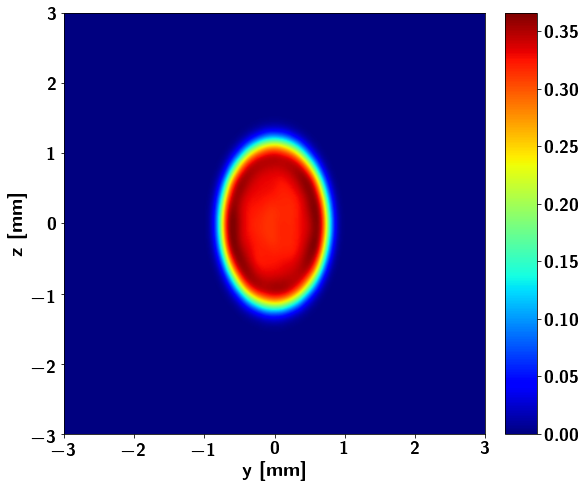

FWHM in x: 1.35507933476625
FWHM in y: 2.061268960335755


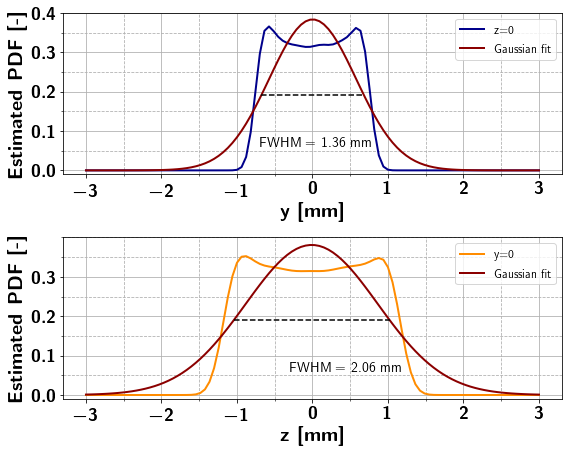

Results for file 07.final_design.no_extraction.2mmFillet.130kV.0.2mesh.ignore_edges.txt:


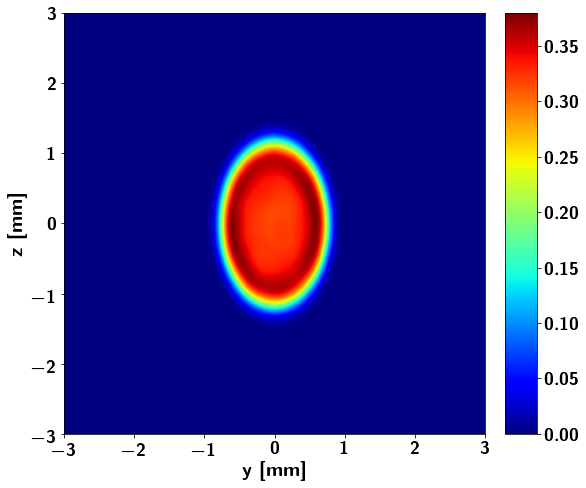

FWHM in x: 1.3468343640847666
FWHM in y: 2.052680095569823


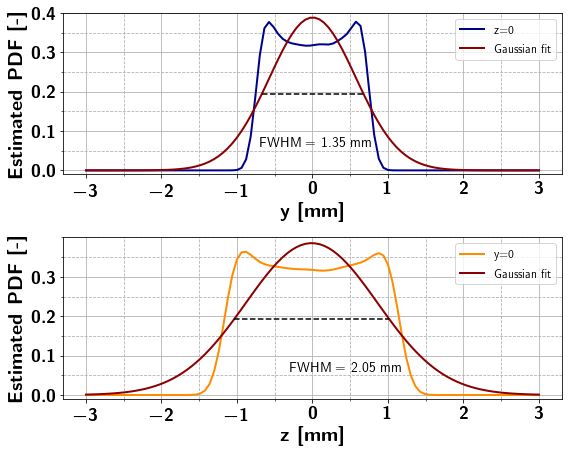

In [17]:
folder = '/Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/03.new_chamber/07.final_design/07.final_design.no_extraction/HV/2mm_fillet/particleData/'
outfolder = '/Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/03.new_chamber/07.final_design/07.final_design.no_extraction/HV/2mm_fillet/particleData/'
files = [f for f in os.listdir(folder) if f.endswith('txt')]
fignames = [f.replace('.txt', '') for f in files]
datafiles = [f"{folder}{f}" for f in files]

for ii in range(0, len(files)):
    print(f"Results for file {files[ii]}:")
    fname = datafiles[ii]
    data = preprocess_COMSOL(fname)
    figname = f"{files[ii]}"
    make_plot_KDE(data, outfolder, figname, max_height=0.4, axis_lim=3)

# 4 mm fillet

Results for file 07.final_design.no_extraction.4mmFillet.60kV.0.2mesh.ignore_edges.txt:


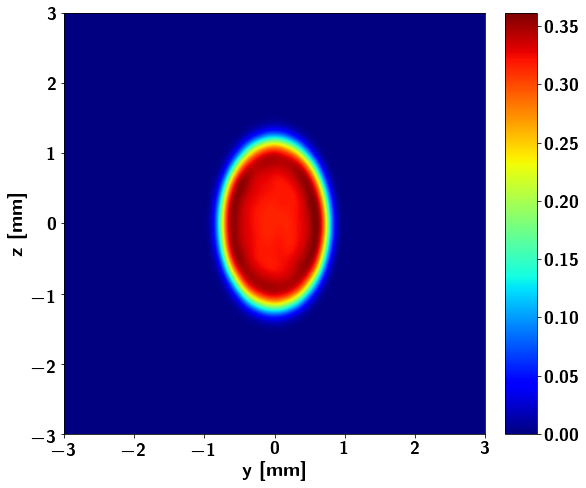

FWHM in x: 1.345808078146532
FWHM in y: 2.0768454349056116


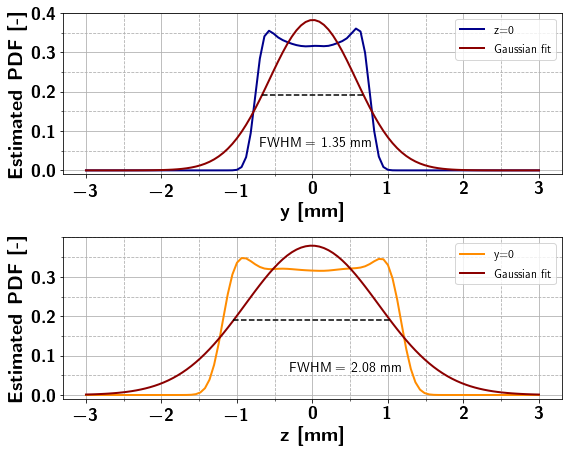

Results for file 07.final_design.no_extraction.4mmFillet.60kV.0.2mesh.txt:


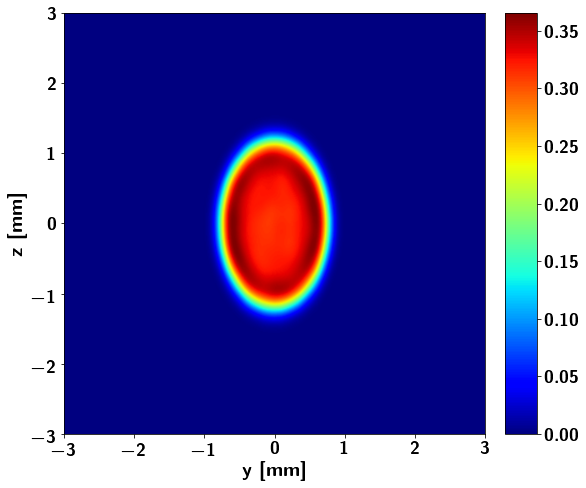

FWHM in x: 1.3500267481874784
FWHM in y: 2.079480452858847


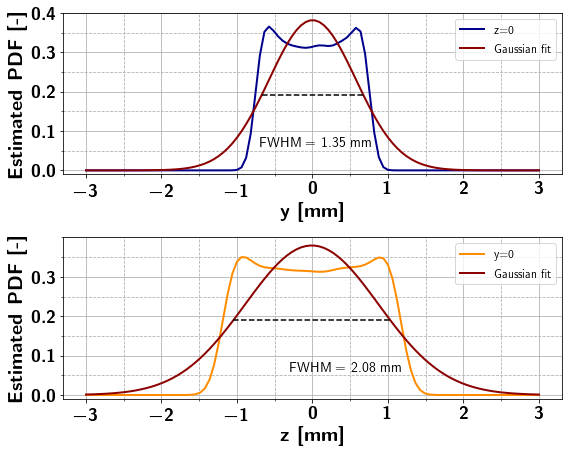

Results for file 07.final_design.no_extraction.4mmFillet.130kV.0.2mesh.txt:


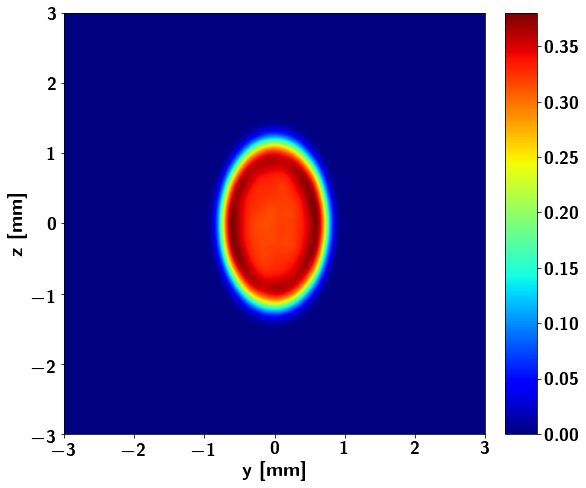

FWHM in x: 1.340123585231108
FWHM in y: 2.0706128673860897


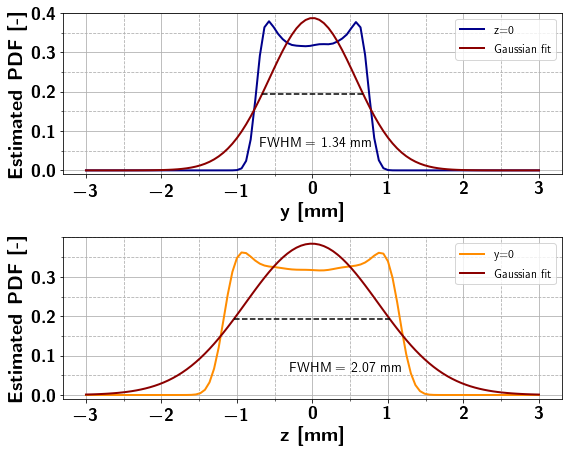

Results for file 07.final_design.no_extraction.4mmFillet.130kV.0.2mesh.ignore_edges.txt:


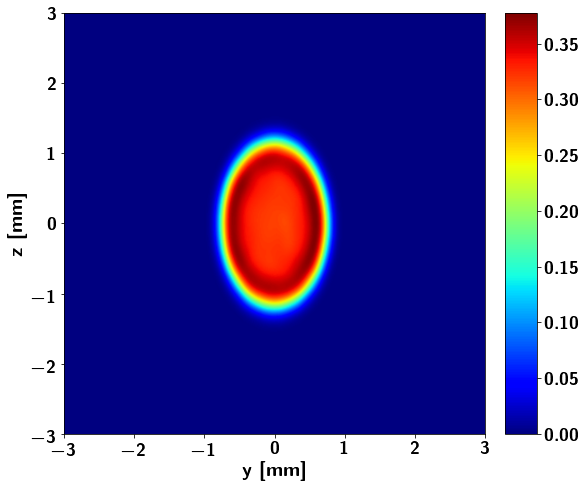

FWHM in x: 1.3367008895794048
FWHM in y: 2.068088627518578


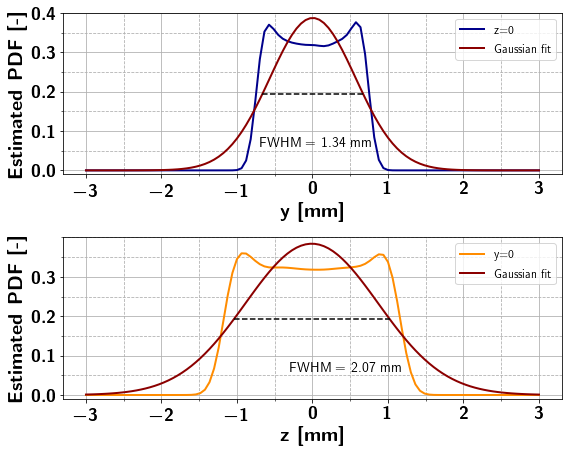

In [18]:
folder = '/Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/03.new_chamber/07.final_design/07.final_design.no_extraction/HV/4mm_fillet/particleData/'
outfolder = '/Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/03.new_chamber/07.final_design/07.final_design.no_extraction/HV/4mm_fillet/particleData/'
files = [f for f in os.listdir(folder) if f.endswith('txt')]
fignames = [f.replace('.txt', '') for f in files]
datafiles = [f"{folder}{f}" for f in files]

for ii in range(0, len(files)):
    print(f"Results for file {files[ii]}:")
    fname = datafiles[ii]
    data = preprocess_COMSOL(fname)
    figname = f"{files[ii]}"
    make_plot_KDE(data, outfolder, figname, max_height=0.4, axis_lim=3)

# refined 4 mm

Results for file 07.final_design.no_extraction.4mmFillet.130kV.0.2mesh.refined.txt:


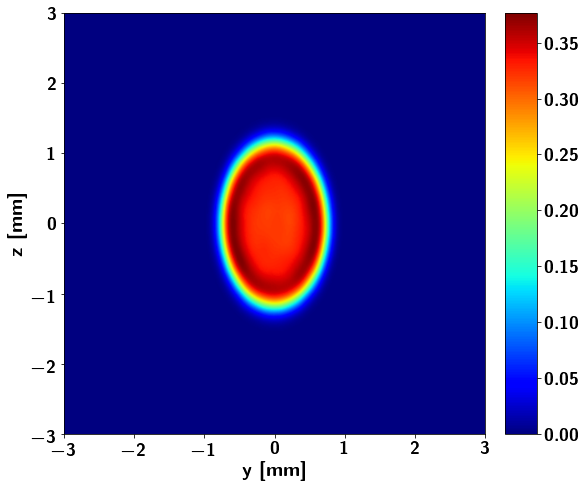

FWHM in x: 1.3380572596597153
FWHM in y: 2.064615408777103


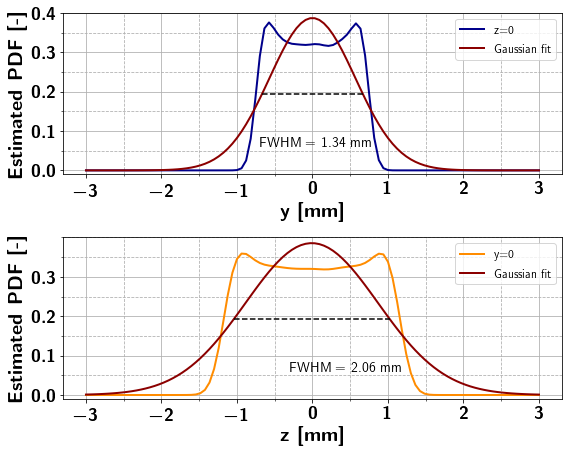

Results for file 07.final_design.no_extraction.4mmFillet.60kV.0.2mesh.refined.txt:


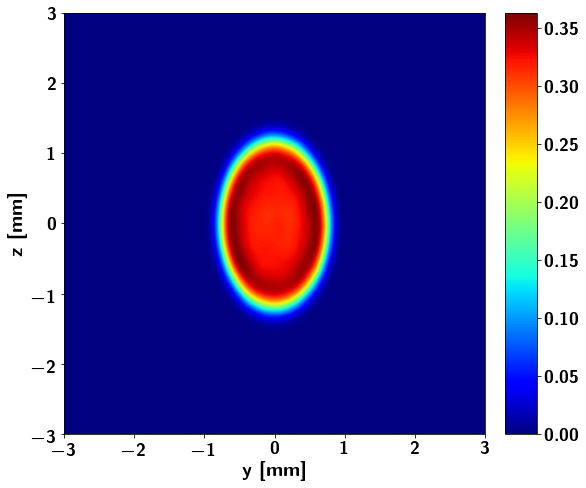

FWHM in x: 1.3477797632746955
FWHM in y: 2.073252336342013


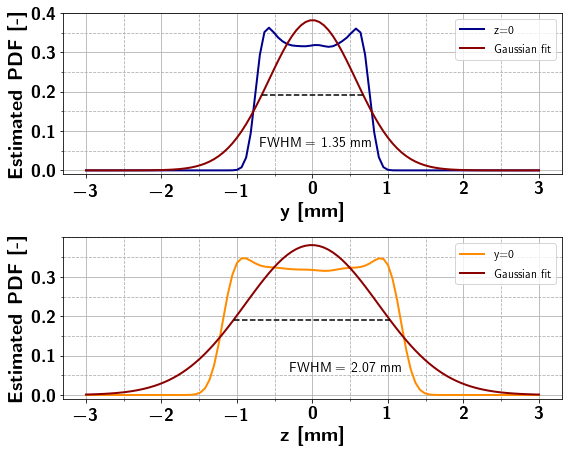

In [19]:
folder = '/Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/03.new_chamber/07.final_design/07.final_design.no_extraction/HV/refined_4mm/particleData/'
outfolder = '/Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/03.new_chamber/07.final_design/07.final_design.no_extraction/HV/refined_4mm/particleData/'
files = [f for f in os.listdir(folder) if f.endswith('txt')]
fignames = [f.replace('.txt', '') for f in files]
datafiles = [f"{folder}{f}" for f in files]

for ii in range(0, len(files)):
    print(f"Results for file {files[ii]}:")
    fname = datafiles[ii]
    data = preprocess_COMSOL(fname)
    figname = f"{files[ii]}"
    make_plot_KDE(data, outfolder, figname, max_height=0.4, axis_lim=3)

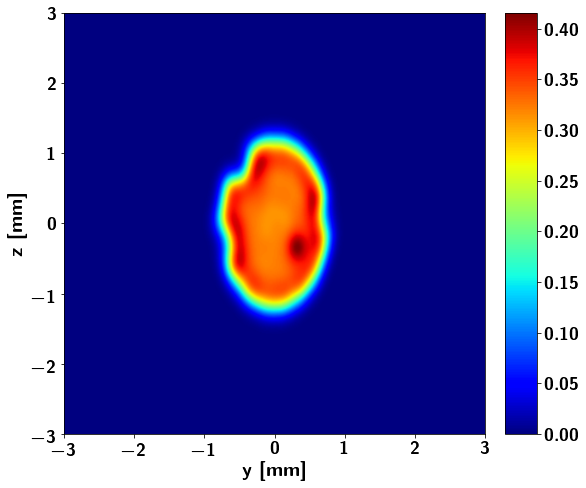

FWHM in x: 1.3140347433979223
FWHM in y: 2.0973799904523003


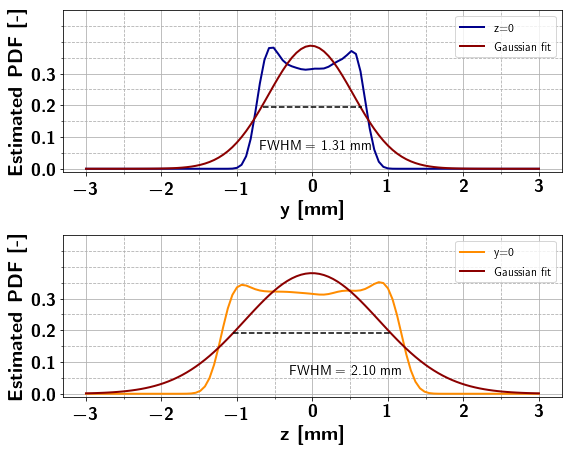

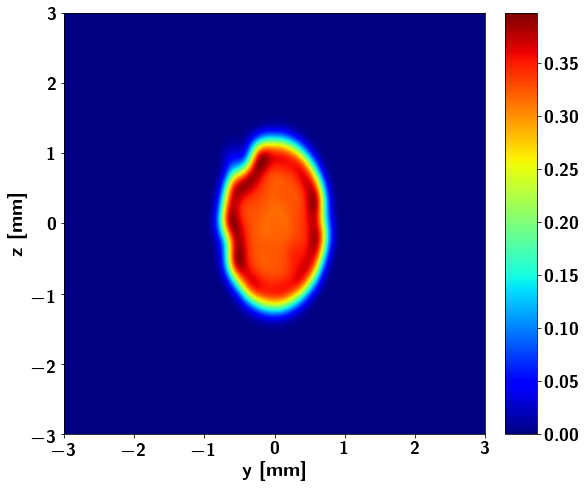

FWHM in x: 1.3165215800287278
FWHM in y: 2.094512429078496


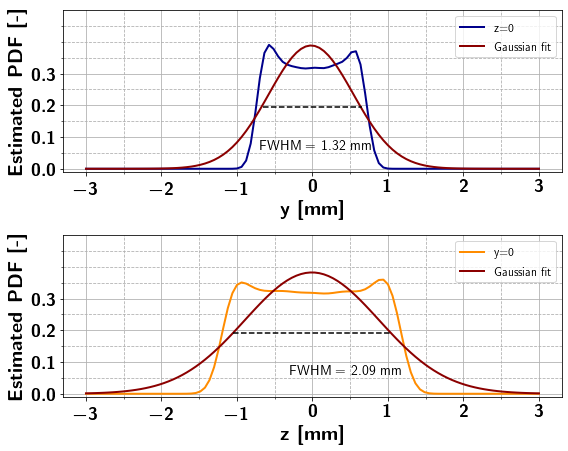

In [14]:
for ii in range(0, len(files)):
    fname = datafiles[ii]
    sweep = sweep_vals[ii]
    dic_dfs = preprocess_COMSOL_sweep(fname, sweep)
    for key in dic_dfs:
        data = dic_dfs[key]
        figname = f"{files[ii]}_{key}"
        make_plot_KDE(data, outfolder, figname, axis_lim=3)